# **MODELAGEM E ESTIMATIVA DOS PARÂMETROS CINÉTICOS PARA PRODUÇÃO DE AMOXILINA**
### ***POR SÍNTESE ENZIMÁTICA EM BIORREATOR BATELADA E BATELADA ALIMENTADA***

In [16]:
#%pip install openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy
import glob
import os

### Importando dados

In [17]:
CIs = []
def convert_ci(ci):
    if type(ci) == str:
        ci_list = [float(i) for i in ci.split('_')]
        return ci_list
    else:
        ci_str = str(ci[0]) + '_' + str(ci[1]) + '_' + str(ci[2]) + '_' + str(ci[3])
        return ci_str
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = '../data/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = {}

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']
    all_times = []
    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        print(file)
        df = df[schema]  # Reorder columns to match the schema
        print(df['apa_t'].max())
        all_times.append(df['apa_t'].to_list())
        ci = df.iloc[0,:4].to_numpy()
        data_frames[convert_ci(ci)] = df
        CIs.append(convert_ci(ci))
    
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]

    return data_frames,csv_files,all_times
data_frames,file_list,all_times = import_dfs()

print(data_frames.keys())
print(data_frames[CIs[0]].columns)
print(file_list)
print(CIs)


../data\25.45nh60ab20.csv
490.0
../data\25.46nh30ab30.csv
490.0
../data\25.47nh5ab80.csv
240.0
../data\5.100nh40ab80.csv
600.0
../data\5.102nh20ab40.csv
540.0
../data\5.103nh40ab30.csv
540.0
../data\5.106nh100ab40.csv
360.0
../data\5.107nh55ab55.csv
50.0
../data\5.109nh5ab55.csv
60.0
../data\5.110nh10ab55.csv
60.0
../data\5.112nh78ab35.csv
360.0
../data\5.48nh20ab80.csv
60.0
../data\5.80nh12ab40.csv
410.0
../data\5.81nh5ab30.csv
285.0
../data\nh60ab80.csv
600.0
dict_keys(['20.0_0.0_60.0_0.0', '30.0_0.0_30.0_0.0', '80.0_0.0_5.0_0.0', '80.0_0.0_40.0_0.0', '40.5_0.0_21.75_3.372620126926563', '30.4_0.0_43.0_2.55', '40.038986354775815_0.0640149834167829_100.04518072289156_1.4210854715202004', '55.0_0.0_55.0_0.623377', '55.0_0.0_5.0_0.0', '55.0_0.0_10.0_0.0', '32.5_0.0_78.0_2.5', '80.0_0.0_20.0_0.0', '38.75_0.0_12.0_1.4', '30.0_0.0_5.0_0.0', '80.0_0.0_60.0_0.0'])
Index(['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm', 'apa_t'], dtype='object')
['25.45nh60ab20', '25.46nh30ab30', '25.47nh5ab80', '5.

### Model

In [18]:
def enzymic_amox(t,y, 
kcat1,
kcat2,
Km1,
Km2,  
Tmax, 
Ken,    
kAOH):
    FAB = 0
    FNH = 0 
    
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]


    # parametros fixados
    kAB          = 3.78 #Constante de inibição do éster (POHPGME)(mM)
    kAN          = 9.174 #Constante de inibição da amoxicilina (mM)
    kAOH         = 10.907 #Constante de inibição do POHPG, produto da hidr�lise da amoxicilina (mM)
    kNH          = 62.044 #Constante de inibição do 6-APA

    Cez = 1

    # Consumo de ester
    VAB = (kcat1*CAB*Cez)/((Km1*(1 + (CAN/kAN) + (CAOH/kAOH))) + CAB)
    
    # Hidrolise de amoxicilina
    VAN = (kcat2*CAN*Cez)/((Km2*(1 + (CAB/kAB) + (CNH/kNH) + (CAOH/kAOH))) + CAN)
    
    # Enzima saturada com 6-apa
    X   = CNH/(Ken + CNH)
    
    # Sintese enzimatica
    VS  = VAB*Tmax*X

    # Hidrolise de ester
    Vh1 = (VAB - VS) 

    dy = np.zeros(4)

    # C. ester
    dy[0] = ((-(VS - VAN) - (Vh1 + VAN)) + FAB) 
    
    # C. amox
    dy[1] = (VS - VAN)                         
    
    # C. 6-apa
    dy[2] = (-(VS - VAN) + FNH)                
    
    # C. POHPG
    dy[3] =  (Vh1 + VAN)
    
    return np.array(dy)      

# ODE Solver - ode15s similar

In [19]:
# ODE15s solver

def ode15s_amox(P, CI, t):
    try:
        sol = scipy.integrate.solve_ivp(
            enzymic_amox, 
            t_span=(t[0], t[-1]), 
            t_eval=t, 
            y0=CI, 
            method='BDF', 
            args=P, 
            #atol=1e-8, 
            #tol=1e-6
        )
        if sol.status != 0:
            raise ValueError("ODE solver failed to converge")
        return sol.y.T
    except Exception as e:
        print(f"Solver failed with error: {e}")
        # Handle solver failure (e.g., return NaNs or retry with different parameters)
        return np.full((len(CI), len(t)), np.nan).T

# Markov-Chain Monte-Carlo com Metropolis Hastings

In [20]:
def mcmc(df,P,name,N=5000,ode_solver=ode15s_amox,status=False,seed=42):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    Np = len(P)
    # Extraindo dados
    CAB_medida  = df.loc[:,'ester_mm'].dropna().to_numpy()
    CAN_medida = df.loc[:,'amox_mm'].dropna().to_numpy()
    CNH_medida = df.loc[:,'apa_mm'].dropna().to_numpy()
    CAOH_medida = df.loc[:,'aoh_mm'].dropna().to_numpy()
    t = df.loc[:,'apa_t'].dropna().to_numpy()
    experiments = [CAB_medida,CAN_medida,CNH_medida,CAOH_medida]

    Cez = 1

    CI = np.array([CAB_medida[0],CAN_medida[0],CNH_medida[0],CAOH_medida[0]])

    Y = ode_solver(P,CI,t)
    CAB_ref   =  Y[:,0]      
    CAN_ref   =  Y[:,1]    
    CNH_ref   =  Y[:,2]      
    CAOH_ref  =  Y[:,3]
    desvio_CAB =  0.1*max(CAB_ref) 
    desvio_CAN =  0.1*max(CAN_ref)
    desvio_CNH =  0.1*max(CNH_ref)
    desvio_CAOH = 0.1*max(CAOH_ref)
    
    waux      = 6e-3 
    media_g   = 1       #Média gaussiana
    desviop_g = 0.6     #Desvio dos parâmetros ao utilizar priori gaussian

    estimate = [i for i in range(Np)]
    Nfix = len(estimate)

    p_ref = P                   
    p_old = P                     

    media_MCMC = media_g*P
    desvio_P   = desviop_g*P

    w = np.ones((1,Np))   
    w = w*waux  

    parametro_exato = (p_ref*np.ones((N,1))).T
    
    aceitacao    = np.zeros((1,N))  
    cadeia       = np.zeros((Np,N)) 
    conv_likeli  = np.zeros((1,N))
    k=0


    Lk_1 = np.dot((CAB_medida - CAB_ref),(CAB_medida - CAB_ref).T) / (desvio_CAB**2)     
    Lk_2 = np.dot((CAN_medida - CAN_ref),(CAN_medida - CAN_ref).T) / (desvio_CAN**2)      
    Lk_3 = np.dot((CNH_medida - CNH_ref),(CNH_medida - CNH_ref).T) / (desvio_CNH**2)       
    Lk_4 = np.dot((CAOH_medida - CAOH_ref),(CAOH_medida - CAOH_ref).T) / (desvio_CAOH**2)  
    
    lk_old = Lk_1 + Lk_2 + Lk_3 + Lk_4
    prior_old = np.sum((((p_old - media_MCMC))/((desvio_P)**2)))
    cadeia[:,0] = p_old
    
    # Contador para verificar a aceitação
    for i in range(0, N):  # Python index starts at 0, MATLAB at 1
        progress = (i / N) * 100
        if status and i % 100 == 0:  # Print progress every 100 iterations
            print(f'Progress: {progress:.3f}%', end='\r')

        # New parameter vector
        P_new = p_old + w * np.random.randn(Np) * p_old
        
        # bounded
        if P_new[0][4] < 0 or P_new[0][4] > 1:
            while P_new[0][4] < 0 or P_new[0][4] > 1:
                P_new = p_old + w * np.random.randn(Np) * p_old
        
        # Simulate using ODE solver
        Y = ode_solver(P_new[0], CI,t)

        CAB  = Y[:,0]
        CAN  = Y[:,1]        
        CNH  = Y[:,2]
        CAOH = Y[:,3]

        # Calculate new prior
        Prior_new = np.sum(((P_new - media_MCMC) / desvio_P) ** 2)

        # Likelihood calculations
        Lk_1 = np.dot((CAB_medida - CAB),(CAB_medida - CAB).T) / (desvio_CAB**2)        
        Lk_2 = np.dot((CAN_medida - CAN),(CAN_medida - CAN).T) / (desvio_CAN**2)         
        Lk_3 = np.dot((CNH_medida - CNH),(CNH_medida - CNH).T) / (desvio_CNH**2)        
        Lk_4 = np.dot((CAOH_medida - CAOH),(CAOH_medida - CAOH).T) / (desvio_CAOH**2)   
    
        Lk_new = Lk_1 + Lk_2 + Lk_3 + Lk_4
        
        # MCMC acceptance check
        if np.log(random.random()) < (-0.5 * (Lk_new + Prior_new - lk_old - prior_old)):
            p_old = P_new
            lk_old = Lk_new
            prior_old = Prior_new
            k += 1
        
        
        # Store results
        aceitacao[0,i] = k
        cadeia[:, i] = p_old
        conv_likeli[0,i] = lk_old + prior_old
    
    fig,ax = plt.subplots(2,5,figsize=[20,8])
    ax = ax.flatten()
    labels = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAOH']

    for idx,g in enumerate(ax):
        g.plot(cadeia[idx,:])    
        g.set_title(labels[idx])
        g.set_ylabel("Value")
        g.set_xlabel("Iteration")
    fig.savefig(f"../results/model_luci_single_rep/chains/{N}_single_{name}.png",dpi=400)
    plt.close()    

    aq = int(0.9 * N)  # Starting index for the burn-in period
    IC = 0.99          # Confidence interval level

    # Confidence interval bounds
    xaux = (1 - IC) / 2
    IC_inf = xaux
    IC_sup = 1 - xaux
    estimate = [i for i in range(Np)]

    amostra = N - aq + 1
    amostras = [] # [CIs, Nics, t, subs]


    output_par = np.zeros((amostra,Np))
    for i in range(len(CIs)):
        t = all_times[i]
        inst_amostra = np.zeros((len(list(range(aq, N + 1))),len(t),4))

        for idx,j in enumerate(range(aq, N + 1)):
            ii = j - aq
            paux = cadeia[:, j - 1]
            output_par[ii,:] = paux
            
            Y = ode_solver(paux,convert_ci(CIs[i]),t)
            inst_amostra[idx,:,0]  = Y[:,0]
            inst_amostra[idx,:,1] = Y[:,1]
            inst_amostra[idx,:,2] = Y[:,2]
            inst_amostra[idx,:,3] = Y[:,3]
        
        amostras.append(inst_amostra)


    AB_media = []
    AN_media = []
    NH_media = []
    AOH_media =[]
    AB_sup = []
    AN_sup = []
    NH_sup = []
    AOH_sup =[]
    AB_inf = []
    AN_inf = []
    NH_inf = []
    AOH_inf =  []   

    for i in range(len(CIs)):
        t = all_times[i]
        amostra = amostras[i]
        
        AB_mean = np.zeros(len(t))
        AB_inferior = np.zeros(len(t))
        AB_superior = np.zeros(len(t))
        NH_mean = np.zeros(len(t))
        NH_inferior = np.zeros(len(t))
        NH_superior = np.zeros(len(t))

        for j in range(len(t)):    
            AB_mean[j] = np.mean(amostra[:,j,0])
            y = np.percentile(amostra[:, j,0], [IC_inf * 100, IC_sup * 100])
            AB_inferior[j] = y[0]
            AB_superior[j] = y[1]

            NH_mean[j] = np.mean(amostra[:, j,2])
            y = np.percentile(amostra[:, j,2], [IC_inf * 100, IC_sup * 100])
            NH_inferior[j] = y[0]
            NH_superior[j] = y[1]
        
        AN_mean = np.zeros(len(t))
        AN_inferior = np.zeros(len(t))
        AN_superior = np.zeros(len(t))
        AOH_mean = np.zeros(len(t))
        AOH_inferior = np.zeros(len(t))
        AOH_superior = np.zeros(len(t))
        
        for j in range(len(t)):
            AN_mean[j] = np.mean(amostra[:, j, 1])
            y = np.percentile(amostra[:, j,1], [IC_inf * 100, IC_sup * 100])
            AN_inferior[j] = y[0]
            AN_superior[j] = y[1]

            AOH_mean[j] = np.mean(amostra[:, j,3])
            y = np.percentile(amostra[:, j,3], [IC_inf * 100, IC_sup * 100])
            AOH_inferior[j] = y[0]
            AOH_superior[j] = y[1]

        AB_media.append(AB_mean)
        NH_media.append(NH_mean)
        AB_inf.append(AB_inferior)
        AB_sup.append(AB_superior)
        NH_inf.append(NH_inferior)
        NH_sup.append(NH_superior)
        AN_media.append(AN_mean)
        AOH_media.append(AOH_mean)
        AN_inf.append(AN_inferior)
        AN_sup.append(AN_superior)
        AOH_inf.append(AOH_inferior)
        AOH_sup.append(AOH_superior)

    # individual plot
    # Ensure 'results' directory exists
    results_dir = f'../results/model_luci_single_rep/'

    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    for i in range(len(CIs)):
        names = ['POH-PGME','Amoxicillin','6-APA','POHPG']
        t = all_times[i]
        style = ['or','og','ob','ok']
        mstyle = ['-r','-g','-b','-k']
        medidas = [
            [AB_media[i], AB_inf[i], AB_sup[i]],
            [AN_media[i], AN_inf[i], AN_sup[i]],
            [NH_media[i], NH_inf[i], NH_sup[i]],
            [AOH_media[i],AOH_inf[i],AOH_sup[i]]
        ]
        fig,ax = plt.subplots(2,2,figsize=(10,10))
        for idx,axis in enumerate(ax.flatten()):
            sname = names[idx]
            medida = medidas[idx]
            
            axis.plot(t, data_frames[CIs[i]].iloc[:,idx].to_numpy(), style[idx], label=sname)
            axis.plot(t, medida[0], mstyle[idx])
            axis.plot(t, medida[1], '--r',linewidth=0.5)
            axis.plot(t, medida[2], '--r',linewidth=0.5) 
            axis.set_xlabel('Tempo (min)')
            axis.set_ylabel(f'Concentração de {sname} (mm)')  # Use f-string for proper string formatting
            axis.legend()  # Adjust legend position
        fig.savefig(os.path.join(results_dir, f"{name}_{N}_{file_list[i]}_mcmc.png"), dpi=300)
        plt.close()  # Close the figure to release memory
    return output_par,k/N

# Distribuição a priori dos parâmetros cinéticos

In [21]:
# luci parameters

kcat1        = 0.178 #Constante catalítica do consumo do éster (mmol/i.u. per min)
 
kcat2        = 0.327 #Constante catalítica da hidrólise da amoxicilina (mmol/i.u. per min)
 
Km1          = 7.905 #Constante de Michaelis-Menten ou constante de afinidade para consumo do éster(mM) 
 
Km2          = 12.509 #Constante de Michaelis-Menten ou constante de afinidade para hidrólise da amoxicilina(mM)
 
Tmax         = 0.606 #Taxa de conversão máxima do complexo acil-enzima-núcleo em produto
 
Ken          = 14.350 #Constante de adsorção do 6-APA
 
kAB          = 3.78 #Constante de inibição do éster (POHPGME)(mM)
 
kAN          = 9.174 #Constante de inibição da amoxicilina (mM)
 
kAOH         = 10.907 #Constante de inibição do POHPG, produto da hidr�lise da amoxicilina (mM)
 
kNH          = 62.044 #Constante de inibição do 6-APA

luci_P = np.zeros(10)
luci_P[0]   = kcat1    
luci_P[1]   = kcat2    
luci_P[2]   = Km1      
luci_P[3]   = Km2      
luci_P[4]   = Tmax     
luci_P[5]   = Ken      
luci_P[6]   = kAOH     
 

In [22]:
priori = luci_P
priori_name = 'luci_adj'

labels = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAOH']

In [23]:
print(file_list)
print(CIs)

['25.45nh60ab20', '25.46nh30ab30', '25.47nh5ab80', '5.100nh40ab80', '5.102nh20ab40', '5.103nh40ab30', '5.106nh100ab40', '5.107nh55ab55', '5.109nh5ab55', '5.110nh10ab55', '5.112nh78ab35', '5.48nh20ab80', '5.80nh12ab40', '5.81nh5ab30', 'nh60ab80']
['20.0_0.0_60.0_0.0', '30.0_0.0_30.0_0.0', '80.0_0.0_5.0_0.0', '80.0_0.0_40.0_0.0', '40.5_0.0_21.75_3.372620126926563', '30.4_0.0_43.0_2.55', '40.038986354775815_0.0640149834167829_100.04518072289156_1.4210854715202004', '55.0_0.0_55.0_0.623377', '55.0_0.0_5.0_0.0', '55.0_0.0_10.0_0.0', '32.5_0.0_78.0_2.5', '80.0_0.0_20.0_0.0', '38.75_0.0_12.0_1.4', '30.0_0.0_5.0_0.0', '80.0_0.0_60.0_0.0']


Currently 0: 25.45nh60ab20 50000
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given

C:\Users\artur\AppData\Local\Temp\ipykernel_2220\3498511840.py:58: RuntimeWarning: invalid value encountered in divide
  prior_old = np.sum((((p_old - media_MCMC))/((desvio_P)**2)))
C:\Users\artur\AppData\Local\Temp\ipykernel_2220\3498511840.py:84: RuntimeWarning: invalid value encountered in divide
  Prior_new = np.sum(((P_new - media_MCMC) / desvio_P) ** 2)


Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymic_amox() takes 9 positional arguments but 12 were given
Solver failed with error: enzymi

IndexError: list index out of range

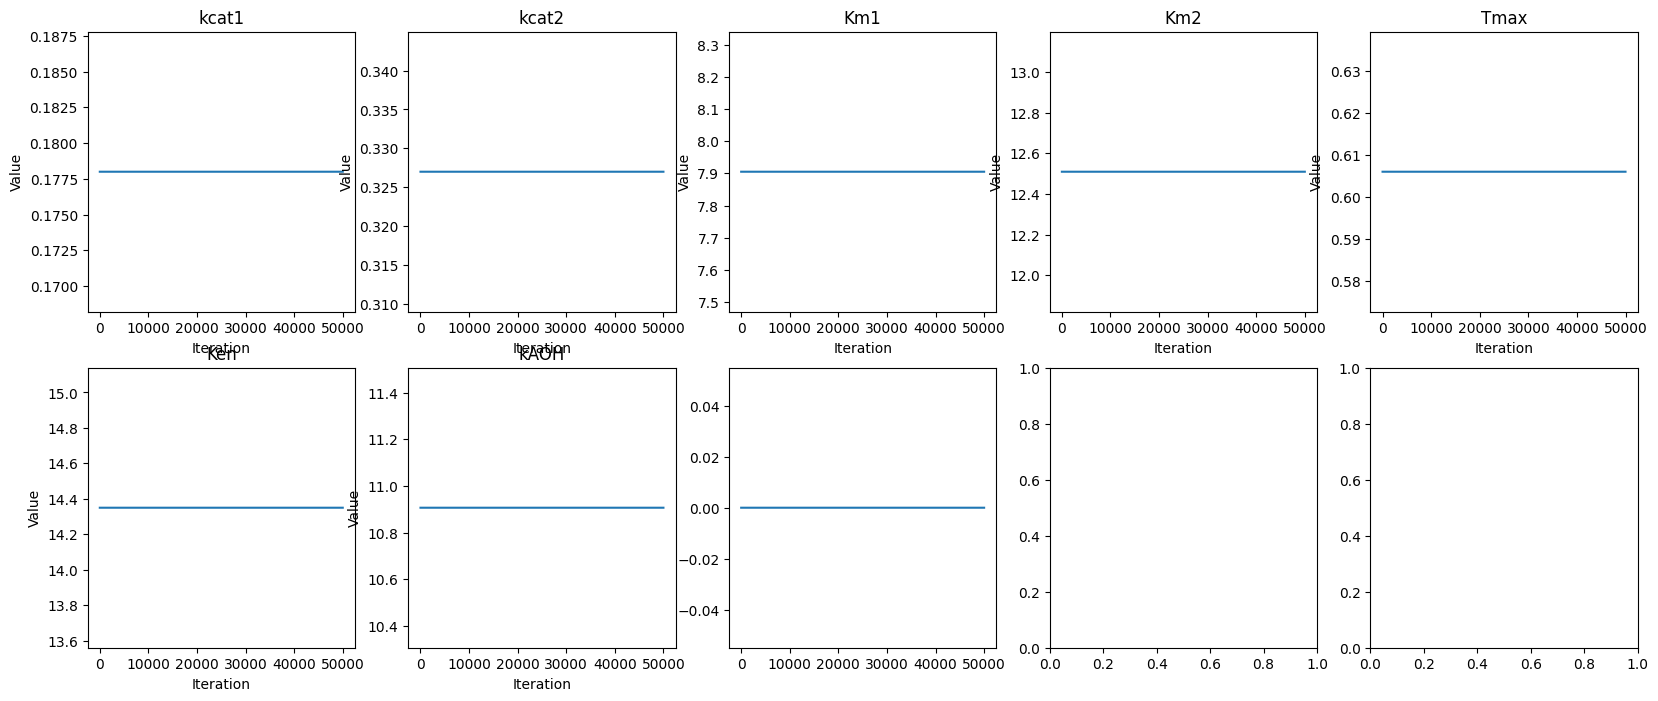

In [ ]:
import os

Ns = [50000]
num_of_replicates = 3
seed = 0

# Define the log file path
log_file_path = "../results/model_luci_single_rep/aceitacao_log_adj.txt"

# Ensure the log file exists by creating it if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, "w") as f:
        pass

with open(log_file_path, "a") as log_file:
    for curr in range(num_of_replicates):
        for N in Ns:
            all_par_df = pd.DataFrame(np.zeros((len(data_frames),len(labels))),columns=labels)
            all_parstderror_df = pd.DataFrame(np.zeros((len(data_frames),len(labels))),columns=labels)
            count = 0
            for ci,name in zip(CIs,file_list):
                
                print(f'Currently {curr}: {name} {N}')
                Ps,aceitacao = mcmc(data_frames[ci],P=priori,name=f"{curr}_{name}_adj",N=N,status=True,seed=seed)
                np.savez_compressed(f'../results/pickles/model_luci_single_rep/{curr}_{N}_{priori_name}_{name}_adj',Ps)
                
                # Log the aceitacao variable
                log_entry = f"{curr}_{N}_{priori_name}_{name}_adj : {aceitacao}\n"
                log_file.write(log_entry)  # Append the formatted entry to the log file
                print('\naceitação: ', aceitacao)
                
                    
                P_conf = pd.DataFrame(Ps)
                P_mean = P_conf.describe().iloc[1,:].to_numpy()
                P_error = P_conf.describe().iloc[2,:].to_numpy() / np.sqrt(P_conf.size)

                for i in range(len(labels)):
                    print(f'{labels[i]}: {P_mean[i]} +- {P_error[i]}')
                
                all_par_df.iloc[count,:] = P_mean
                all_parstderror_df.iloc[count,:] = P_error
                count += 1
                seed += 1

            all_par_df.to_csv(f'../results/model_luci_single_rep/par_adj/{curr}_{N}_{priori_name}_mean.csv')
            all_parstderror_df.to_csv(f'../results/model_luci_single_rep/par_adj/{curr}_{N}_{priori_name}_error.csv')

In [ ]:
Ns = [100000]
seed = 30
curr = 2
for N in Ns:
    all_par_df = pd.DataFrame(np.zeros((len(data_frames),len(labels))),columns=labels)
    all_parstderror_df = pd.DataFrame(np.zeros((len(data_frames),len(labels))),columns=labels)
    count = 0
    for ci,name in zip(CIs,file_list):
        
        print(f'Currently {curr}: {name} {N}')
        Ps,aceitacao = mcmc(data_frames[ci],P=priori,name=f"{curr}_{name}",N=N,status=True,seed=seed)
        np.savez_compressed(f'../results/pickles/rep/{curr}_{N}_{priori_name}_{name}',Ps)
        print('\naceitação: ',aceitacao)
    
            
        P_conf = pd.DataFrame(Ps)
        P_mean = P_conf.describe().iloc[1,:].to_numpy()
        P_error = P_conf.describe().iloc[2,:].to_numpy() / np.sqrt(P_conf.size)

        for i in range(len(labels)):
            print(f'{labels[i]}: {P_mean[i]} +- {P_error[i]}')
        
        all_par_df.iloc[count,:] = P_mean
        all_parstderror_df.iloc[count,:] = P_error
        count += 1
        seed +=1

    all_par_df.to_csv(f'../results/model_luci_single_rep/{curr}_{N}_{priori_name}_mean.csv')
    all_parstderror_df.to_csv(f'../results/model_luci_single_rep/{curr}_{N}_{priori_name}_error.csv')

Currently 2: 25.45nh60ab20 100000
Progress: 99.900%
aceitação:  0.97282
kcat1: 0.014601160643534315 +- 3.850900218298084e-06
kcat2: 0.07482870529047489 +- 6.21428928293106e-05
Km1: 0.06635796589769333 +- 8.555585883406442e-05
Km2: 20.423592708325007 +- 0.015341267072797236
Tmax: 0.25857735099366885 +- 7.171608582082381e-05
Ken: 11.657655062112001 +- 0.00822203159651021
kAB: 0.4274331836832543 +- 0.00019797643691455146
kAN: 2.5996965669956644 +- 0.0013419612187573842
kAOH: 4.077342208111878 +- 0.0021706957333606056
kNH: 53.41145355756865 +- 0.041988892498159375
Currently 2: 25.46nh30ab30 100000
Progress: 99.900%
aceitação:  0.9232
kcat1: 0.072352995807697 +- 1.7896570235715854e-05
kcat2: 0.47389986566774267 +- 0.00018182150386069173
Km1: 4.729954952356515 +- 0.0029684527849423202
Km2: 16.234205777238863 +- 0.01055323360792534
Tmax: 0.5645178354214813 +- 0.00013541326639752584
Ken: 2.8450790654803835 +- 0.0024222906350099987
kAB: 4.038615529121022 +- 0.004015846523439072
kAN: 12.74665456

C:\Users\artur\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_ivp\bdf.py:416: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


Progress: 99.900%
aceitação:  0.87646
kcat1: 0.3479500109523402 +- 3.6335058146583174e-05
kcat2: 0.5065361627533232 +- 0.0003089427664717077
Km1: 0.44511637813970206 +- 0.00045017225570801665
Km2: 1.7286223672693797 +- 0.0011081882660475514
Tmax: 0.4164197003534898 +- 5.661853404686362e-05
Ken: 1.6709040011563563 +- 0.001223308055736078
kAB: 1.6472435028788375 +- 0.0011243043387096409
kAN: 0.17504027314033738 +- 0.00013947927099246767
kAOH: 6.119520852357597 +- 0.0026599147057896444
kNH: 48.83794461748157 +- 0.03438087389146956
Currently 2: 5.80nh12ab40 100000
Progress: 99.900%
aceitação:  0.93708
kcat1: 0.07827700717211562 +- 1.1352885757875115e-05
kcat2: 0.17839120851284865 +- 8.271476604073354e-05
Km1: 0.3678494313853662 +- 0.0005780238376459797
Km2: 0.036504175320891195 +- 3.338428088809442e-05
Tmax: 0.512657155289588 +- 0.00026614055859315225
Ken: 1.8625925721331043 +- 0.002331310404899892
kAB: 0.09913659277207162 +- 5.8333338209415394e-05
kAN: 3.0139841481786194 +- 0.001323515731